<a href="https://colab.research.google.com/github/pwilczewski/open_source_rmbs/blob/main/Open_source_analysis_of_the_Fed's_RMBS_portfolio_(part_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Analysis summary
In this multi-part series I provide an open source analysis of the Fed's RMBS portfolio. In part 1 I forecasted the portfolio's cash flows and balances to contractual maturity. In part 2 I value the portfolio and assess its risk characteristics. Next in part 3 I will project the taxpayer liability that would result from recapitalizing future operating losses.

In this notebook I estimate the value and risk characteristics of the portfolio using the treasury yield curve for discounting. My baseline analysis estimates that as-of 10/19/2022 the net present value of the portfolio is &#36;2,394 billion or 89.02 per 100 of outstanding face amount. Assuming the Fed's liabilities are valued at par, the RMBS portfolio contributes 295 billion to the capital shortfall on the Fed's balance sheet. Additionally each additional basis point of interest rate increase will result in an estimated 1.5 billion decline in the portfolio's valuation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install QuantLib
import QuantLib as ql
from os import path

if not path.exists('open_source_rmbs/processed_data.csv'):
  !git clone https://github.com/pwilczewski/open_source_rmbs
mbs_data = pd.read_csv("open_source_rmbs/processed_data.csv", index_col=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 40.7 MB/s 
Cloning into 'open_source_rmbs'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 12), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (34/34), done.


# 2. Yield curve data summary
For this analysis I use the Treasury yield curve to discount the portfolio cash flows. I calculate the discount factors using data from the [treasury par yield curve](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2022) as-of 10/19/2022. I exclude the 20-year maturity due to ongoing concerns about liquidity for those instruments.

In [2]:
class TreasuryParCurve():
  def __init__(self, maturities, rates, asof_date):

    convention = ql.Unadjusted
    compounding = ql.Compounded
    freq = ql.Semiannual
    day_count = ql.ActualActual(ql.ActualActual.Bond)
    ql.Settings.instance().evaluationDate = asof_date
    self.asof_date = asof_date

    bonds = []
    for r, m in zip(rates, maturities):
      # ql.Schedule(effectiveDate, terminationDate, tenor, calendar, convention, terminationDateConvention, rule, endOfMonth)
      schedule = ql.Schedule(asof_date, asof_date + m, ql.Period(ql.Semiannual), ql.UnitedStates(), convention, convention, ql.DateGeneration.Backward, True)
      # ql.FixedRateBondHelper(price, settlementDays, faceAmount, schedule, coupons, dayCounter, paymentConv=Following)
      helper_base = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(100)), 0, 100.0, schedule, [r/100.0], day_count, convention,)
      bonds.append(helper_base)

    self.treasury_curve = ql.PiecewiseLogCubicDiscount(asof_date, bonds, day_count)

  def calculate_df(self, period_range):
    return [self.treasury_curve.discount(self.asof_date+ql.Period(m, ql.Months)) for m in period_range]

asof_date = ql.Date(19, 10, 2022)
term_points = [1, 2, 3, 4, 6, 12, 24, 36, 60, 84, 120, 360]
rates = [3.31, 3.72, 4.07, 4.32, 4.45, 4.60, 4.55, 4.56, 4.35, 4.26, 4.14, 4.15]
maturities = [ql.Period(t, ql.Months) for t in term_points]
base_curve = TreasuryParCurve(maturities, rates, asof_date)


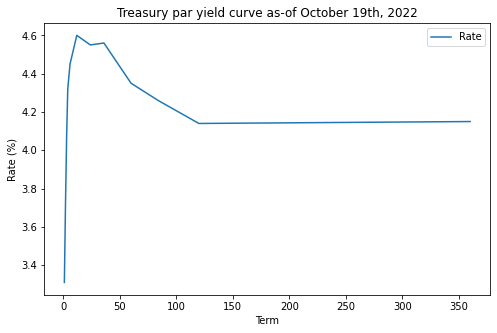

In [3]:
yield_curve = pd.DataFrame({"Term": term_points, "Rate": rates})
yield_curve.plot(x="Term", y="Rate",figsize=(8,5))
plt.title("Treasury par yield curve as-of " + str(asof_date))
plt.ylabel("Rate (%)")
plt.show()

# 3. Portfolio valuation
I calculate the cash flows of each security using the cash flow methodology and assumptions described in part 1. Then I discount these cash flows using the treasury yield curve to calculate the net present value of each security. To estimate the value of the entire RMBS portfolio I rescale the sum of all the security values by the 95\% size of my data sample. I find that the net present value of the portfolio is 2,394 billion. Given the face amount of 2,690 billion the price of this portfolio relative to par is 89.02.

In [4]:
def static_pricing(mbs_data, cpr, discount_factors):

  prices = []

  for i in range(len(mbs_data)):
    loan = mbs_data.iloc[i]
    note_rate = loan['note_rate']/1200
    coupon = loan['coupon']/1200
    term = loan['term'].astype(int)
    age = loan['age'].astype(int)
    initial_bal = loan['curr_bal']

    smmfactors = np.power(1-cpr/1200,range(1,term-age+1))
    amfactors = ((1+note_rate)**term - (1+note_rate)**(range(age+1,term+1)))/((1+note_rate)**term - 1)
    initial_amfactor = ((1+note_rate)**term - (1+note_rate)**age)/((1+note_rate)**term - 1)
    amfactors = smmfactors*amfactors/initial_amfactor
    amfactors = np.insert(amfactors,0,1)
    balance = initial_bal*amfactors
    int_pymts = balance[0:-1]*coupon
    prin_pymts = balance[0:-1] - balance[1:]

    price = 100*np.sum(discount_factors[0:term-age]*(int_pymts + prin_pymts))/initial_bal
    prices.append(price)

  price_frame = pd.DataFrame({"price": prices, "balance": mbs_data['curr_bal']})
  return price_frame

base_df = base_curve.calculate_df(range(1,361))
mbs_prices = static_pricing(mbs_data, 6, base_df)



Average price           89.02
Balance outstanding  $2690.0B
Estimated value      $2394.6B
Capital shortfall    $-295.4B




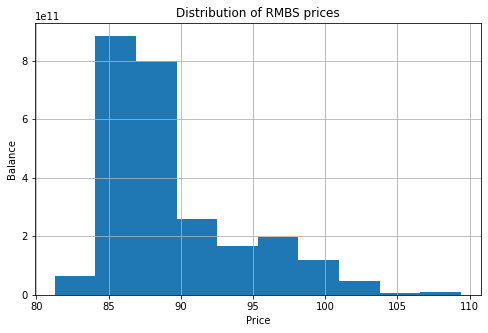

In [5]:

wavg_price = np.sum(mbs_prices['price']*mbs_prices['balance'])/np.sum(mbs_prices['balance'])
total_bal = sum(mbs_prices['balance'])/0.95

outframe = pd.DataFrame([str(np.round(wavg_price,2)), 
                         "$" + str(np.round(total_bal/10**9,1))+"B",
                         "$" + str(np.round(wavg_price/100*total_bal/10**9,1))+"B",
                         "$" + str(np.round((wavg_price/100-1)*total_bal/10**9,1))+"B"],
                        index=['Average price', 'Balance outstanding', 'Estimated value', 'Capital shortfall'])

print("\n")
print(outframe.to_string(header=False))
print("\n")

mbs_prices['price'].hist(weights=mbs_prices['balance'],figsize=(8,5))
plt.xlabel("Price")
plt.ylabel("Balance")
plt.title("Distribution of RMBS prices")
plt.show()


# 4. Portfolio risk
Finally I estimate the interest rate risk of the Fed's portfolio by calculating the effective duration and DV01. The effective duration measures the sensitivity of price to interest rate changes for each security. I calculate the effective duration using +/-25 basis point shocks to the treasury par curve. Then I calculate the DV01 by estimating the change in portfolio value for each 1 bp change in rates.

Using this methodology I find the effective duration of the portfolio is 6.72 and the DV01 is &#36;1.53 billion.



Average duration: 	 6.72
Portfolio DV01: 	 $1.53B




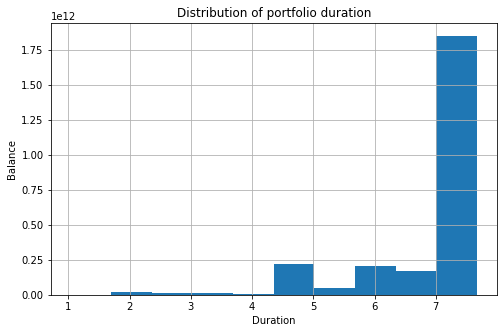

In [6]:

curve_up25 = TreasuryParCurve(maturities, [r+0.25 for r in rates], asof_date)
curve_down25 = TreasuryParCurve(maturities, [r-0.25 for r in rates], asof_date)
prices_up25 = static_pricing(mbs_data, 6, curve_up25.calculate_df(range(1,361)))
prices_down25 = static_pricing(mbs_data, 6, curve_down25.calculate_df(range(1,361)))

duration = (prices_down25['price'] - prices_up25['price'])/(0.5*mbs_prices['price']/100)
wavg_duration = np.sum(mbs_prices['balance']*duration)/np.sum(mbs_prices['balance'])
portfolio_duration = wavg_duration*np.sum(mbs_prices['balance']*mbs_prices['price']/100)/10000

print("\n")
print("Average duration: \t", np.round(wavg_duration,2))
print('Portfolio DV01: \t', "$" + str(np.round(portfolio_duration/10**9,2)) + "B")
print("\n")

duration.hist(weights=mbs_prices['balance'], figsize=(8,5))
plt.xlabel("Duration")
plt.ylabel("Balance")
plt.title("Distribution of portfolio duration")
plt.show()
